In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/dcx_mid_project/DCX_Mid_Project

/content/drive/MyDrive/dcx_mid_project/DCX_Mid_Project


In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 24 not upgraded.
Need to get 4,850 kB of archives.
After this operation, 16.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1 [1,598 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr amd64 4.1.1-2build2 [262 kB]
Fetched 4,850 kB in 3s (1,905 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/Fro

In [ ]:
from imutils.perspective import four_point_transform
import matplotlib.pyplot as plt
import pytesseract
import imutils
import cv2
import re
import requests
import numpy as np
from google.colab.patches import cv2_imshow
import re

In [27]:
def length_from_image(img_url):
    imageOrgCp = cv2.imread(img_url)                      # 원본 이미지 불러오기
    imageOrgCp = cv2.resize(imageOrgCp, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
    height, width, channel = imageOrgCp.shape             # 원본 이미지 크기 저장
    center = (width//2, height//2)                        # 이미지 center값 저장
    grayCp = cv2.cvtColor(imageOrgCp, cv2.COLOR_BGR2GRAY) # 이미지 흑백으로 전환

    grayCp = cv2.bitwise_not(grayCp)          # 이미지 색반전
    threshold = 250                           # 숫자영역만 원래 0에 가까울것으로 추정되기때문에 색반전후 250 이상인값만 숫자일것으로 추정
    ret, mask = cv2.threshold(grayCp, threshold, 255, cv2.THRESH_BINARY_INV)  # threshold를 사용해 숫자영역을 제외한 나머지 부분 0으로 변환
    mask = cv2.bitwise_not(mask)              # mask영역 색 반전

    img_blurred = cv2.GaussianBlur(mask, ksize=(3, 3), sigmaX=0)  # 숫자영역중 흰색과 경계인 부분은 실제 0에 가까운값이 아니었기때문에 굉장히 얇은 실선 형태로 변환되었기때문에 가우시안 블러를 사용해 모양을 다시 살림

    img_blurred = 255-img_blurred             #
    ret, mask = cv2.threshold(img_blurred, threshold, 255, cv2.THRESH_BINARY_INV)

    # cv2_imshow(mask)

    contours, _ = cv2.findContours(
        mask, 
        mode=cv2.RETR_LIST, 
        method=cv2.CHAIN_APPROX_SIMPLE
    )

    temp_result = np.zeros((height, width), dtype=np.uint8)

    contours_dict = []

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(temp_result, pt1=(x, y), pt2=(x+w, y+h), color=255, thickness=-1)
        
        # insert to dict
        contours_dict.append({
            'x': x,
            'y': y,
            'w': w,
            'h': h,
            'cx': x + (w / 2),
            'cy': y + (h / 2)
        })
    # cv2_imshow(temp_result)

    bit_and = cv2.bitwise_and(grayCp, temp_result)

    # cv2_imshow(bit_and)
    serch_list = []
    for i in range(0, 360, 5):
        M = cv2.getRotationMatrix2D(center, i, 1.0)
        rotated = cv2.warpAffine(bit_and, M, (width,height))
        chars = pytesseract.image_to_string(255-rotated, config='--psm 6')
        serch_list.append(re.search("\d+cm", chars))

    len_dict = {}
    for item in serch_list:
        if item != None:
            try:
                len_dict[item.group()] += 1
            except:
                len_dict[item.group()] = 1
    sorted_dict = sorted(len_dict.items(), key = lambda item: item[1], reverse=True)
    if len(sorted_dict) > 0 :
      x, y = sorted_dict[0]
      return int(x.replace('cm', ''))
    return 0



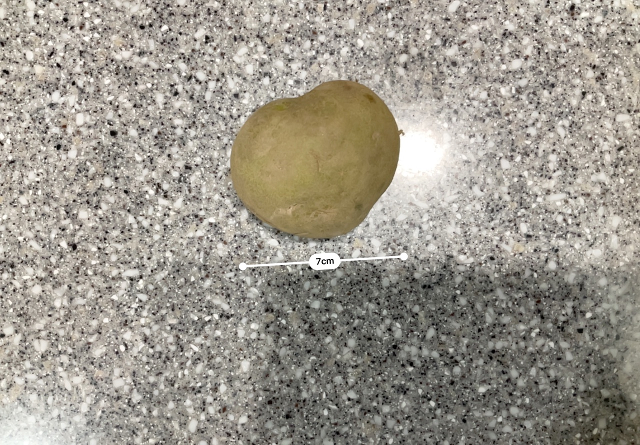

In [15]:
img = cv2.imread("/content/drive/MyDrive/dcx_mid_project/DCX_Mid_Project/length/test_img/po1.jpg")

img = cv2.resize(img, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_CUBIC)
cv2_imshow(img)

In [28]:
img_len = length_from_image("/content/drive/MyDrive/dcx_mid_project/DCX_Mid_Project/length/test_img/po1.jpg")

In [29]:
img_len

7

In [ ]:
import os
dir_path = "/content/drive/MyDrive/dcx_mid_project/DCX_Mid_Project/length"

for (root, directories, files) in os.walk(dir_path):
    # for d in directories:
    #     d_path = os.path.join(root, d)
    #     print(d_path)

    for file in files:
        file_path = os.path.join(root, file)
        len_dict = length_from_image(file_path)
        print(file_path, len_dict)

/content/drive/MyDrive/dcx_mid_project/DCX_Mid_Project/length/10cm/chilipepper_10cm.jpg [('10cm', 5), ('40cm', 1)]
/content/drive/MyDrive/dcx_mid_project/DCX_Mid_Project/length/11cm/chilipepper_11cm_1.jpg [('11cm', 3)]
/content/drive/MyDrive/dcx_mid_project/DCX_Mid_Project/length/11cm/chilipepper_11cm_2.jpg [('11cm', 3), ('41cm', 1)]
/content/drive/MyDrive/dcx_mid_project/DCX_Mid_Project/length/11cm/onion_11cm.jpg [('11cm', 3), ('41cm', 1)]
/content/drive/MyDrive/dcx_mid_project/DCX_Mid_Project/length/11cm/chilipepper_11cm_3.jpg [('11cm', 3)]
/content/drive/MyDrive/dcx_mid_project/DCX_Mid_Project/length/2cm/garlic_2cm.jpg [('2cm', 5)]
/content/drive/MyDrive/dcx_mid_project/DCX_Mid_Project/length/3cm/garlic_3cm_1.jpg [('3cm', 6)]
/content/drive/MyDrive/dcx_mid_project/DCX_Mid_Project/length/3cm/garlic_3cm_2.jpg [('3cm', 5)]
/content/drive/MyDrive/dcx_mid_project/DCX_Mid_Project/length/3cm/garlic_3cm_3.jpg [('3cm', 4), ('38cm', 2)]
/content/drive/MyDrive/dcx_mid_project/DCX_Mid_Project/l

In [ ]:
test = re.search("\d+cm", "11cm, 22cm, 13cm")

In [ ]:
test

<re.Match object; span=(0, 4), match='11cm'>